# Purpose

This notebook performs a very simple experiment to test the conjecture that the function $[\mathbf{e}^T\mathbf{A} - \mathbf{A}\mathbf{e}]_i$ is a Lyapunov function of the (deterministic) dynamics for each $i$ iff $\beta < 2$. 
This would imply that the set of balanced matrices is a global attractor of the dynamics in this case. 

In [21]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
def compute_gamma(A, beta):
    
    # ignore some warning messages surfaced by SpringRank
    np.seterr(divide='ignore', invalid='ignore') 
    
    # compute springranks
    phi = SpringRank.SpringRank(A, alpha = 0)
    
    # exponentiate
    gamma = np.exp(beta * phi)
    
    # normalize
    gamma = gamma / gamma.sum()
    
    return(gamma)    

In [55]:
# construct the increment to add to the current state. Either stochastic or deterministic. def increment(n, gamma, method = 'stochastic'):    

def increment(n, gamma, method = 'stochastic'):
    if method == 'stochastic':
        j = np.random.randint(n)           # uniformly random department gets to hire
        i = np.random.choice(n, p = gamma) # chooses from departments proportional to $\gamma$. 
        E = np.zeros((n,n))
        E[i,j] = 1
        return(E)
    
    elif method == 'deterministic': 
        G = np.tile(gamma, (n,1)).T        # G is the expectation of E above 

        return(G)

# Generate Synthetic Data

In [781]:
# test data
# T is the kind of data we would actually observe
# A is a series of state matrices dependent on lambda. 

n = 20
beta = 2
n_rounds = 50
lam = .9

T0 = np.ones((n,n))
T0 = np.random.randint(10, 20, size = (n,n))
T0 = T0 / T0.sum()*150

T = np.zeros((n_rounds, n, n))

A = np.zeros_like(T)

T[0] = T0
A[0] = T0

for j in range(1,n_rounds): 
    
    T[j] = T[j-1]
    gamma = compute_gamma(A[j-1], beta) 
    
    num_increment = np.random.randint(100,200) # can change
    to_add = np.zeros((n,n))
    
    for k in range(num_increment):
        to_add += increment(n, gamma, 'stochastic')
    
    T[j] += to_add
    
    A[j] = lam*A[j-1] + (1-lam)*to_add
    

In [782]:
# next task is to do multinomial maximum likelihood 

In [783]:
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = compute_gamma(A[k], beta)

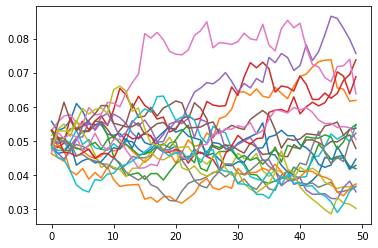

In [784]:
for l in range(n):
    plt.plot(GAMMA[:,l])

# Basic Inference Procedure

In [785]:
def state_matrix(T, lam):
    n_rounds = T.shape[0]
    DT = np.diff(T, axis = 0)
    A = np.zeros_like(T)
    A[0] = T[0]
    for j in range(1,n_rounds):
        A[j] = lam*A[j-1]+(1-lam)*DT[j-1]
    return(A)

In [786]:
# inputs are DT and A
# Do we have access to A in general? 
# Conditional on knowing lambda, yes, right? 

def LL(T, lam):
        
    n_rounds, n = T.shape[0], T.shape[1]
        
    A = state_matrix(T,lam)
    DT = np.diff(T, axis = 0)
    increments = DT.sum(axis = 0)

    S = np.zeros((n_rounds-1,n))
    for i in range(0,n_rounds-1):
        S[i] = SpringRank.SpringRank(A[i])

    counts = DT.sum(axis = 2)    

    def ll(beta):
        first = (beta*counts*S).sum()
        second = (counts.sum(axis = 1)*np.log(np.exp(beta*S).sum(axis = 1))).sum()

        return(first - second)
    
    return(ll)

In [787]:
lam_grid = 51
b_grid = 51

LAM = np.linspace(lam-.1, np.min((lam+.1,1)), lam_grid)

BETA = np.linspace(beta  - 1, beta + 1, b_grid)

In [788]:
# evaluate the likelihood surface
M = np.zeros((lam_grid, b_grid))
for l in range(lam_grid):
    ll = LL(T,LAM[l])
    M[l] = np.array([ll(b) for b in BETA])

# estimates
ix = np.where(M == M.max())
beta_hat = BETA[ix[1]]
lambda_hat = LAM[ix[0]]

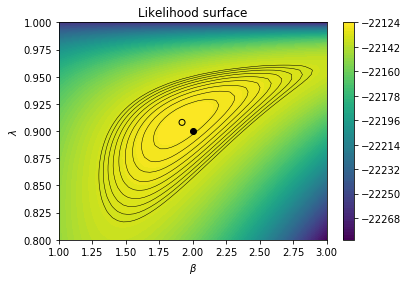

In [789]:
# plotting

fig = plt.figure()
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAM)

im = ax.contourf(xg, yg, M, levels = 100)
ax.contour(xg, yg, M, 
           levels = np.linspace(M.max()-10, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.scatter(beta, lam, color = 'black')

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood surface')


plt.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')